In [1]:
import os
import pySuStaIn
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from utils import biomarker_selection

In [2]:
diabetes = 't2dm'
dm_type = 'pre'
thres = 0.3
sustain_result_path = f'results/{diabetes}_{dm_type}_thres{thres}/pickle_files/'
biomarkers, num_biomarkers, direction = biomarker_selection(threshold=thres)

Selected 18 biomarkers for modeling:
HbA1c, BMI, HDLc, TyG, HLS_Retic, Glucose, RET, IRF, ApoA, ALT, TG, Urate, WBC, CHOL, CRP, LYM, LDLc, Vitamin_D


In [3]:
# load the original data
covariates = ['Sex', 'Age', 'Drinking_status', 'Smoking_status', 'Education', 'Income']
df_data = pd.read_csv(f'data/data_{diabetes}_{dm_type}_balanced_no_outliers.csv')

In [4]:
# load the results for different subtypes 0-3
sustain_result0 = pickle.load(open(sustain_result_path + f'{diabetes}_{dm_type}_subtype0.pickle', 'rb'))
sustain_result1 = pickle.load(open(sustain_result_path + f'{diabetes}_{dm_type}_subtype1.pickle', 'rb'))
sustain_result2 = pickle.load(open(sustain_result_path + f'{diabetes}_{dm_type}_subtype2.pickle', 'rb'))
# sustain_result3 = pickle.load(open(sustain_result_path + f'{diabetes}_{selection}_top{num_biomarkers}_subtype3.pickle', 'rb'))

In [ ]:
prob_s1= sustain_result1['prob_ml_subtype']

In [5]:
# concat sustain results with the original data
result_names = [
    'ml_subtype', # the assigned subtype
    'prob_ml_subtype', # the probability of the assigned subtype
    'ml_stage', # the assigned stage 
    'prob_ml_stage',
]
for var in result_names:
    df_data[var] = sustain_result0[var]
    df_data[var + '_1'] = sustain_result1[var]
    df_data[var + '_2'] = sustain_result2[var]
    # df_data[var + '_3'] = sustain_result3[var]

In [7]:
# save the results
result_path = f'results/{diabetes}_{dm_type}_thres{thres}/saved_results/'
os.makedirs(result_path, exist_ok=True)

In [8]:
df_data['Subtype'] = 'Subtype ' + (df_data['ml_subtype_1'] + 1).astype(int).astype(str)
print(df_data['Subtype'].value_counts())

Subtype
Subtype 1    20773
Subtype 2    19837
Name: count, dtype: int64


In [9]:
df_data.to_csv(os.path.join(result_path, f'sustain_results_biomarkers.csv'), index=False)

In [10]:
from utils import zscore_regressed_out_covariates

# Parameters
N_startpoints = 25  # startpoints
N_S_max = 2  # maximum number of subtypes
N_iterations_MCMC = int(1e5)  # number of iterations for MCMC
SuStaInLabels = biomarkers  # labels for the biomarkers
dataset_name = diabetes  # name of the dataset
output_folder = f'results/{diabetes}_{dm_type}_thres{thres}/'

# regress out covariates
# zscore for IDPs and biomarkers
df_data_zscored = zscore_regressed_out_covariates(df_data, diabetes, biomarkers, covariates)

zdata = df_data_zscored[SuStaInLabels].values
# setup z_vals and z_max
z_max = np.quantile(zdata, 0.95, axis=0)

# z_vals for each SuStaInLabels from 0 to z_max, 3 breakpoints, shape (len(SuStaInLabels), 3)
# z_vals = []
# for i in range(len(SuStaInLabels)):
#     z_vals.append(np.linspace(0, z_max[i], 3)[1:])
# z_vals = np.array(z_vals)
z_vals = np.array([[1, 2]] * len(SuStaInLabels))

sustain_input = pySuStaIn.ZscoreSustain(
                              zdata,
                              z_vals,
                              z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              True)

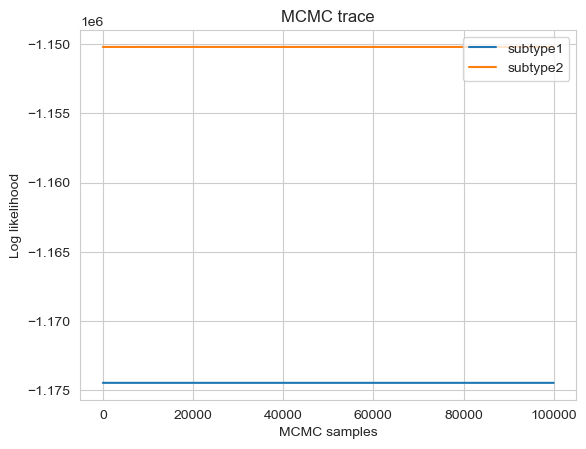

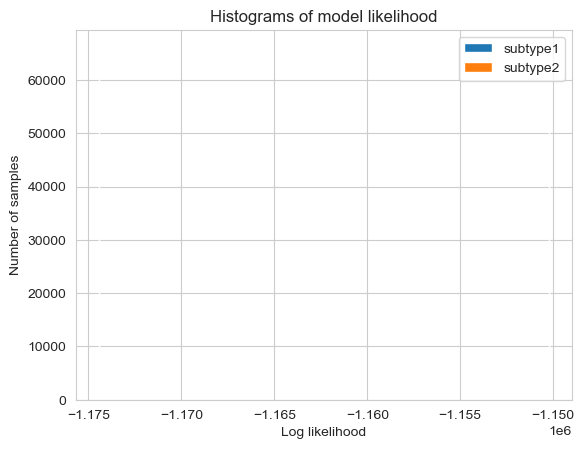

In [11]:
# Let's plot positional variance diagrams to interpret the subtype progressions
import matplotlib.pyplot as plt
# for each subtype model max 2 subtype
for s in range(2):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = sustain_result_path + f'{diabetes}_{dm_type}_subtype{s}.pickle'
    pk = pd.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s + 1))
    plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    # save figure
    plt.savefig(os.path.join(result_path, f'{diabetes}_subtype{s}_mcmc_trace.png'), bbox_inches='tight', dpi=300)

    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s + 1))
    plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')
    # save figure
    plt.savefig(os.path.join(result_path, f'{diabetes}_subtype{s}_histogram.png'), bbox_inches='tight', dpi=300)

<Axes: xlabel='ml_stage_1', ylabel='Count'>

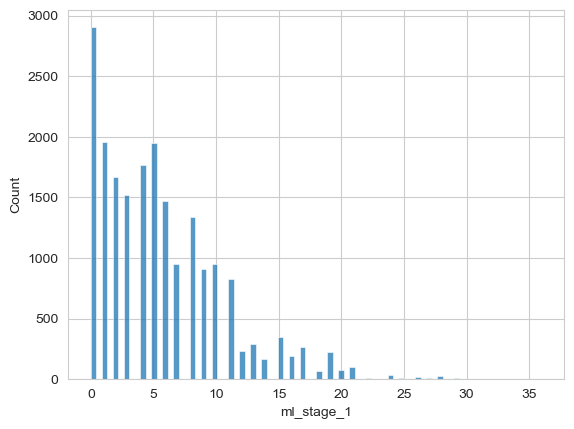

In [12]:
# histogram of assigned stages and subtypes
sns.histplot(data=df_data[df_data[diabetes] == 1], x='ml_stage_1')

<Axes: xlabel='Subtype', ylabel='Count'>

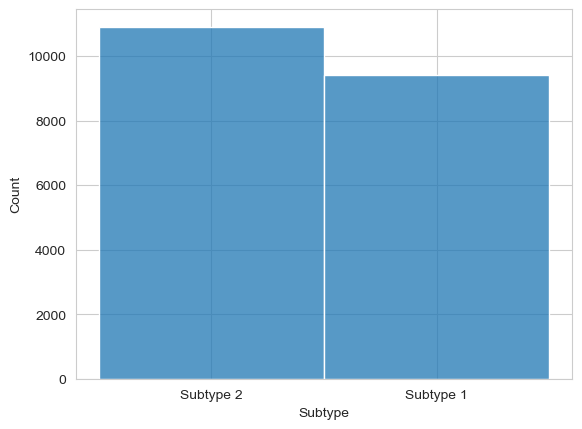

In [13]:
sns.histplot(data=df_data[df_data[diabetes] == 1], x='Subtype')

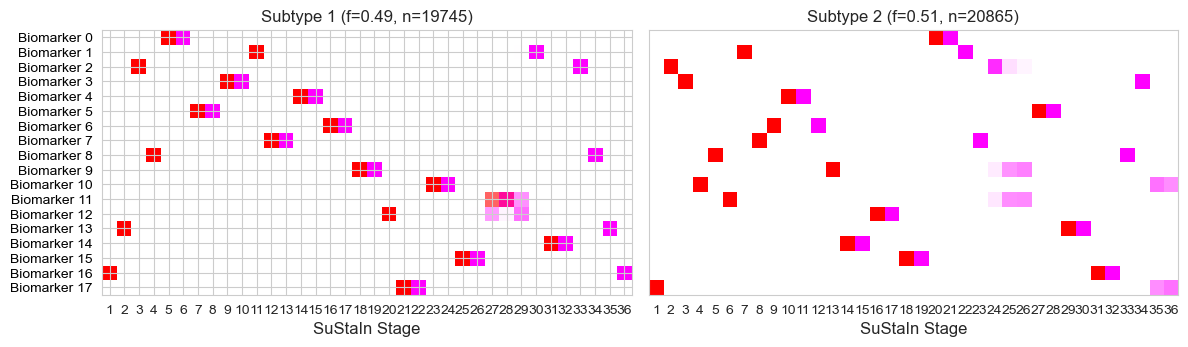

In [14]:
samples_sequence = sustain_result1['samples_sequence']
samples_f = sustain_result1['samples_f']
pySuStaIn.ZscoreSustain._plot_sustain_model(sustain_input, samples_sequence, samples_f, len(df_data), subtype_order=(0, 1), figsize=(12, 15))
plt.grid(False)

In [15]:
df_idps = pd.read_csv(f'data/data_587idp_v2.csv')

df_idps = pd.merge(df_data[['Eid', 't2dm'] + covariates + ['ml_subtype', 'ml_subtype_1', 'ml_stage', 'ml_stage_1', 'Subtype']], df_idps, on='Eid')

df_time_diff = pd.read_csv('data/time_diff_mri.csv')
df_idps = pd.merge(df_idps, df_time_diff, on='Eid')
# df_idps.to_csv(os.path.join(result_path, 'sustain_results_idps.csv'), index=False)

In [16]:
# count stages
# save path for stage count
os.makedirs(os.path.join(result_path, 'stage_count'), exist_ok=True)
df_idps_dm = df_idps[df_idps[diabetes] == 1].copy()
x = df_idps_dm.groupby(['Subtype', 'ml_stage_1']).size().reset_index(name='counts')
x['ml_stage_1'] = x['ml_stage_1'].astype(int).astype(str)
# save to csv
x.to_csv(os.path.join(result_path, 'stage_count', 'subtype_stage_counts.csv'), index=False)
print(df_idps_dm['Subtype'].value_counts())
print(x)

Subtype
Subtype 2    614
Subtype 1    520
Name: count, dtype: int64
      Subtype ml_stage_1  counts
0   Subtype 1          0     102
1   Subtype 1          1      39
2   Subtype 1          2      30
3   Subtype 1          3      41
4   Subtype 1          4      35
5   Subtype 1          5      32
6   Subtype 1          6      25
7   Subtype 1          7      25
8   Subtype 1          8      32
9   Subtype 1          9      34
10  Subtype 1         10      41
11  Subtype 1         11      27
12  Subtype 1         12       6
13  Subtype 1         13      10
14  Subtype 1         14       5
15  Subtype 1         15      11
16  Subtype 1         16       3
17  Subtype 1         17       8
18  Subtype 1         18       1
19  Subtype 1         19       5
20  Subtype 1         20       2
21  Subtype 1         21       5
22  Subtype 1         28       1
23  Subtype 2          0      97
24  Subtype 2          1      63
25  Subtype 2          2      46
26  Subtype 2          3      54
27  Subt

In [17]:
# merge stages for subtype 1
# def merge_stages(stage):
#     if stage in [0]:
#         return 1
#     elif stage in [1, 2, 3]:
#         return 2
#     elif stage in [4, 5, 6, 7]:
#         return 3
#     elif stage in [8, 9, 10]:
#         return 4
#     else : # >= 11
#         return 5
# 
# # merge stages for subtype 2
# def merge_stages2(stage):
#     if stage in [0]:
#         return 1
#     elif stage in [1, 2]:
#         return 2
#     elif stage in [3, 4]:
#         return 3
#     elif stage in [5, 6, 7]:
#         return 4
#     else : # >= 11
#         return 5
def merge_stages(stage):
    if stage <= 4:
        return 1
    elif stage <= 10:
        return 2
    else:
        return 3

def merge_stages2(stage):
    if stage <= 3:
        return 1
    elif stage <= 7:
        return 2
    # elif stage in [28, 32]:
    #     return -1 # not used (outliers)
    else:
        return 3

In [18]:
# merge stages for subtypes separately
df_data['stage1'] = df_data['ml_stage_1'].apply(merge_stages)
df_data['stage2'] = df_data['ml_stage_1'].apply(merge_stages2)
# if subtype 1, use stage1, else use stage2
df_data['Stage'] = df_data.apply(lambda x: x['stage1'] if x['ml_subtype_1'] == 0 else x['stage2'], axis=1)
# drop stage1 and stage2
df_data = df_data.drop(columns=['stage1', 'stage2'])
df_idps['Stage1'] = df_idps['ml_stage_1'].apply(merge_stages)
df_idps['Stage2'] = df_idps['ml_stage_1'].apply(merge_stages2)
# if subtype 1, use stage1, else use stage2
df_idps['Stage'] = df_idps.apply(lambda x: x['Stage1'] if x['ml_subtype_1'] == 0 else x['Stage2'], axis=1)
# drop stage1 and stage2
df_idps = df_idps.drop(columns=['Stage1', 'Stage2'])

In [19]:
# merge stages for subtypes separately
df_idps_dm['Stage1'] = df_idps_dm['ml_stage_1'].apply(merge_stages)
df_idps_dm['Stage2'] = df_idps_dm['ml_stage_1'].apply(merge_stages2)
# if subtype 1, use stage1, else use stage2
df_idps_dm['Stage'] = df_idps_dm.apply(lambda x: x['Stage1'] if x['ml_subtype_1'] == 0 else x['Stage2'], axis=1)
# drop stage1 and stage2
df_idps_dm = df_idps_dm.drop(columns=['Stage1', 'Stage2'])
x2 = df_idps_dm.groupby(['Subtype', 'Stage']).size().reset_index(name='counts')
x2['Stage'] = x2['Stage'].astype(int).astype(str)
# save to csv
x2.to_csv(os.path.join(result_path, 'stage_count', 'subtype_stage_counts_merged.csv'), index=False)
print(x2)

     Subtype Stage  counts
0  Subtype 1     1     247
1  Subtype 1     2     189
2  Subtype 1     3      84
3  Subtype 2     1     260
4  Subtype 2     2     207
5  Subtype 2     3     147


In [20]:
df_data_dm = df_data[df_data[diabetes] == 1].copy()
x3 = df_data_dm.groupby(['Subtype', 'Stage']).size().reset_index(name='counts')
x3['Stage'] = x3['Stage'].astype(int).astype(str)
# save to csv
x3.to_csv(os.path.join(result_path, 'stage_count', 'subtype_stage_counts_merged_all.csv'), index=False)
print(x3)

     Subtype Stage  counts
0  Subtype 1     1    4130
1  Subtype 1     2    3393
2  Subtype 1     3    1879
3  Subtype 2     1    4536
4  Subtype 2     2    3937
5  Subtype 2     3    2430


In [21]:
df_idps['time_diff_int'] = df_idps['time_diff_mri'].apply(lambda x: int(x))

In [22]:
# save the results
df_data.to_csv(os.path.join(result_path, f'sustain_results_biomarkers.csv'), index=False)

In [23]:
# order by subtype, stage, and time_diff
df_idps_sorted = df_idps.sort_values(by=['Subtype', 'Stage', 'time_diff_int'])
df_idps_sorted.to_csv(os.path.join(result_path, 'sustain_results_idps_sorted.csv'), index=False)

In [24]:
# count by subtype and stage, and time_diff_int
x4 = df_idps_sorted.groupby(['Subtype', 'Stage', 'time_diff_int']).size().reset_index(name='counts')
x4.to_csv(os.path.join(result_path, 'stage_count', 'subtype_stage_time_diff_counts.csv'), index=False)

In [25]:
# time bins
def time_bins(time_diff):
    if time_diff < 7:
        return '4-7 years'
    elif time_diff < 10:
        return '7-10 years'
    else:
        return '10+ years'
df_idps_sorted['Time_bins'] = df_idps_sorted['time_diff_mri'].apply(time_bins)

In [26]:
# count by subtype, stage, and time_bins
x5 = df_idps_sorted.groupby(['Subtype', 'Stage', 'Time_bins']).size().reset_index(name='counts')
# sort by subtype, stage, and time_bins
x5 = x5.sort_values(by=['Subtype', 'Time_bins', 'Stage'])
x5.to_csv(os.path.join(result_path, 'stage_count', 'subtype_stage_time_bins_counts.csv'), index=False)
print(x5)

      Subtype  Stage   Time_bins  counts
0   Subtype 1      1   10+ years     363
3   Subtype 1      2   10+ years     103
6   Subtype 1      3   10+ years      35
1   Subtype 1      1   4-7 years     160
4   Subtype 1      2   4-7 years      33
7   Subtype 1      3   4-7 years      17
2   Subtype 1      1  7-10 years     479
5   Subtype 1      2  7-10 years     126
8   Subtype 1      3  7-10 years      55
9   Subtype 2      1   10+ years     375
12  Subtype 2      2   10+ years      78
15  Subtype 2      3   10+ years      59
10  Subtype 2      1   4-7 years     154
13  Subtype 2      2   4-7 years      40
16  Subtype 2      3   4-7 years      20
11  Subtype 2      1  7-10 years     459
14  Subtype 2      2  7-10 years     101
17  Subtype 2      3  7-10 years      68


In [27]:
df_idps['Time_bins'] = df_idps['time_diff_mri'].apply(time_bins)
df_idps.to_csv(os.path.join(result_path, 'sustain_results_idps.csv'), index=False)

In [28]:
print(df_data_dm['Subtype'].value_counts())

Subtype
Subtype 2    10903
Subtype 1     9402
Name: count, dtype: int64


In [29]:
# zscore for IDPs and biomarkers
IDPs = df_idps.columns[df_idps.columns.str.contains('IDP')]
df_idps_zscored = zscore_regressed_out_covariates(df_idps, diabetes, IDPs, covariates)
# save zscored results
df_idps_zscored.to_csv(os.path.join(result_path, 'sustain_results_idps_zscored.csv'), index=False)

In [30]:
df_data_zscored = zscore_regressed_out_covariates(df_data, diabetes, biomarkers, covariates)
df_data_zscored.to_csv(os.path.join(result_path, 'sustain_results_biomarkers_zscored.csv'), index=False)